# Reinforcement Learning for Lunar Lander game

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
% matplotlib notebook

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Defining hyperparameters:

Here we define all the hyperparameters for the model, this will allow as to easily iterate and find the values that give best results.

In [2]:
num_episodes = 900      # Number of episodes for training
learning_rate = 0.01
gamma = 0.99           # Discount factor for reward
num_Hidden = 100       # number of nodes in the hidden layer

env = gym.make('LunarLander-v2')    # Choose a game and create an environment
# env = env.unwrapped              # The wrapper limits the number of steps in an episode to 200, let's get rid of it
obs_dim = env.reset().shape      # obervation dimension
num_actions = env.action_space.n # number of actions (this works only for descrete action space, which is the case here)

### Define functions

**Discount reward function**: We we'll train our agent based on the reward gained for his actions. For each action we'll define the episode reward as the total reward gained in all the next steps of the current episode. Since a reward gained further away in the future has less correlation to the present action, we will give it less weight by discounting future rewards.

The formula for the discounted rewards is given by:

$$ R_t = \sum_k \gamma^k r_{t+k} $$

Where $r_t$ is the reward gained in the step $t$ and $\gamma \in [0,1]$ is a hyperparameter called the discount factor.
Here we define a function that takes a vector of rewards in consequent steps and returns the discounted reward vector:

In [3]:
def discount_rewards(r):
    '''Takes a 1D rewards (one episode) and discounts it and also standardize
    the rewards to be unit normal (helps control the gradient estimator variance)'''
    
    # Discounting
    dis_r = np.zeros_like(r)
    running_sum = 0
    for t in reversed(range(len(r))):
        running_sum = gamma*running_sum + r[t]
        dis_r[t] = running_sum
    
    # Normailzing
    dis_r = (dis_r - np.mean(dis_r))/np.std(dis_r)
        
    return dis_r

### Build model

To keep order in our model, we use name scopes which basically group the layers of our model in a simple to follow way. Eventually, when using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) for visualizing the model, the graph is more readable and makes it easy to understand the model and find errors.

In [4]:
'''Create placeholders for inputs'''
# A place holder for input observations
input_ = tf.placeholder(tf.float32, shape = (None, obs_dim[0]), name = "input")
# A place holder for actions in a full episode
actions = tf.placeholder(tf.float32, shape = (None, num_actions), name = "actions")
# A place holder for discounted rewards in a full episode
dis_rewards = tf.placeholder(tf.float32, shape = (None, ), name = "dis_rewards")

'''Fully connected layers'''
with tf.name_scope("FC1"):
    fc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "fc1" )

with tf.name_scope("FC2"):
    fc2 = tf.layers.dense(inputs = fc1, units = num_actions ,activation = None, name = "fc2" )

with tf.name_scope("Action_PDF"):
    # Operate with softmax on fc2 outputs to get an action probability distribution
    action_prob_dist = tf.nn.softmax(logits = fc2, name = "softamx")

with tf.name_scope("Loss"):
    '''Define loss'''
    # Fist define reular softmax cross entropy loss
    CE_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = actions, logits = fc2, name = "CE_loss")
    # Modulate the loss based on our discounted reward - this is where reinforcment learning happens,
    # we favor actions that produced high reward
    loss = tf.reduce_mean(CE_loss * dis_rewards)

with tf.name_scope("Training"):
    '''Define optimizer'''
    training_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

'''Define saver for saving and restoring model'''
saver = tf.train.Saver()

Define a writer for saving summaries to TensorBoard:

In [5]:
# writer = tf.summary.FileWriter("./tensorboard/1/")

Here is an example of a graph visualization:

<img src="./img/model_graph.png" width="500">

Each block in the graph is expandable and let you see the content inside, for example see an [image](./img/model_graph_loss.png) with expanded loss block.

### Train model

Now that we have a model ready, we can start training it.

Our goal is to achieve a model that uses the current observation to create the best probability distribution function (PDF) for the next action to be taken. This is **not a deterministic model** - the agent has a fine probability to take any action after receiving an observation, with larger probability to take favorable actions.

To achieve that, in each step, we use our model to generate a PDF of actions, draw an action out of it and take the next step.
When we reach the end of the episode, we compute the episode loss by feeding the observation, action and discounted rewards vectors (which we kept track of). Our optimizer minimizes the loss which makes favorable (unfavorable) actions more probable (less probable) due to the multiplicative factor of the discounted reward. By repeating these steps to each episode, our agent gradually improves its PDF and becomes a better player!

In [6]:
ep_action, ep_obs, ep_reward = [], [], []  # Allocate space for episode actions, observations and rewards
tot_ep_reward = [] # Total episode reward
mean_reward = []

''' Run TF session '''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ''' Run episodes '''
    for ep in range(num_episodes): 
        obs = env.reset()  # Reset and save first observation
        ep_obs.append(obs) # append observation

        ''' Run steps '''
        while True:
            # Propagate forward to compute action probability distribution
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
            action = np.random.choice(np.arange(num_actions), p = apd)   # Sample an action based on the pdf
            obs, reward, done, info = env.step(action)  # Take action and save observation, reward and done boolean
            
            # Convert action to one hot
            action_oh = np.zeros((1,num_actions))
            action_oh[0,action] = 1
            
            ep_action.append(action_oh)  # append action
            ep_obs.append(obs)           # append observation
            ep_reward.append(reward)     # append reward

            if done: 
                # Stack vertically episode parameters to one np.array
                ep_action = np.vstack(ep_action)
                ep_obs = np.vstack(ep_obs)
                ep_reward = np.hstack(ep_reward)

                # Discount rewards
                dis_rewards_arr = discount_rewards(ep_reward)
                # Compute loss and optimize
                sess.run([loss, training_opt],
                         feed_dict = {input_ : ep_obs[:-1], actions : ep_action, dis_rewards : dis_rewards_arr})
                
                tot_ep_reward.append(np.sum(ep_reward))  # Compute total reward for episode
                mean_reward.append(np.mean(tot_ep_reward))
                
                 # print info
                print("-------------------------------------------------")
                print("Episode {}".format(ep))
                print("Episode ended after {} steps".format(ep_action.shape[0]))
                print("Accumulated reward in this episode {}".format(tot_ep_reward[ep]))
                print("Mean reward so far {:0.2f}".format(np.mean(tot_ep_reward)))
                print("Maximal reward so far {}".format(np.max(tot_ep_reward)))
                
                ep_action, ep_obs, ep_reward = [], [], []  # Clear episode values for next episode
                      
                break
                
    saver.save(sess, "models/LunarLander/model.ckpt") # save model for later
#     writer.add_graph(sess.graph) # Save graph for displaying with TensorBoard
env.close()

-------------------------------------------------
Episode 0
Episode ended after 79 steps
Accumulated reward in this episode -144.28473740847414
Mean reward so far -144.28
Maximal reward so far -144.28473740847414
-------------------------------------------------
Episode 1
Episode ended after 83 steps
Accumulated reward in this episode -251.22790748673913
Mean reward so far -197.76
Maximal reward so far -144.28473740847414
-------------------------------------------------
Episode 2
Episode ended after 76 steps
Accumulated reward in this episode -88.67931530671784
Mean reward so far -161.40
Maximal reward so far -88.67931530671784
-------------------------------------------------
Episode 3
Episode ended after 106 steps
Accumulated reward in this episode -154.4320511838854
Mean reward so far -159.66
Maximal reward so far -88.67931530671784
-------------------------------------------------
Episode 4
Episode ended after 95 steps
Accumulated reward in this episode -192.6090899163873
Mean rew

-------------------------------------------------
Episode 39
Episode ended after 277 steps
Accumulated reward in this episode -180.31033041100707
Mean reward so far -129.39
Maximal reward so far 25.89019864324291
-------------------------------------------------
Episode 40
Episode ended after 283 steps
Accumulated reward in this episode -54.89374877111379
Mean reward so far -127.57
Maximal reward so far 25.89019864324291
-------------------------------------------------
Episode 41
Episode ended after 275 steps
Accumulated reward in this episode -107.28703188702676
Mean reward so far -127.09
Maximal reward so far 25.89019864324291
-------------------------------------------------
Episode 42
Episode ended after 186 steps
Accumulated reward in this episode -55.25435711182907
Mean reward so far -125.42
Maximal reward so far 25.89019864324291
-------------------------------------------------
Episode 43
Episode ended after 171 steps
Accumulated reward in this episode -97.27662946212563
Mean 

-------------------------------------------------
Episode 78
Episode ended after 441 steps
Accumulated reward in this episode -182.12821500917258
Mean reward so far -110.35
Maximal reward so far 35.39997291442817
-------------------------------------------------
Episode 79
Episode ended after 309 steps
Accumulated reward in this episode -97.93031839731128
Mean reward so far -110.20
Maximal reward so far 35.39997291442817
-------------------------------------------------
Episode 80
Episode ended after 118 steps
Accumulated reward in this episode -68.83797853461257
Mean reward so far -109.69
Maximal reward so far 35.39997291442817
-------------------------------------------------
Episode 81
Episode ended after 493 steps
Accumulated reward in this episode -195.16347218975514
Mean reward so far -110.73
Maximal reward so far 35.39997291442817
-------------------------------------------------
Episode 82
Episode ended after 110 steps
Accumulated reward in this episode -45.02672549844729
Mean 

-------------------------------------------------
Episode 117
Episode ended after 1000 steps
Accumulated reward in this episode -69.65820112678136
Mean reward so far -100.65
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 118
Episode ended after 256 steps
Accumulated reward in this episode -246.5676946666053
Mean reward so far -101.87
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 119
Episode ended after 117 steps
Accumulated reward in this episode -12.36136916726366
Mean reward so far -101.13
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 120
Episode ended after 269 steps
Accumulated reward in this episode -85.49942201457053
Mean reward so far -101.00
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 121
Episode ended after 320 steps
Accumulated reward in this episode -126.01547949872634


-------------------------------------------------
Episode 157
Episode ended after 782 steps
Accumulated reward in this episode -293.35478605035644
Mean reward so far -91.71
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 158
Episode ended after 166 steps
Accumulated reward in this episode 36.345476275537315
Mean reward so far -90.90
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 159
Episode ended after 199 steps
Accumulated reward in this episode -23.159960196355982
Mean reward so far -90.48
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 160
Episode ended after 1000 steps
Accumulated reward in this episode 10.745773986011415
Mean reward so far -89.85
Maximal reward so far 78.94428824847166
-------------------------------------------------
Episode 161
Episode ended after 1000 steps
Accumulated reward in this episode -28.949754790830262
M

-------------------------------------------------
Episode 196
Episode ended after 285 steps
Accumulated reward in this episode 29.74863164776868
Mean reward so far -71.54
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 197
Episode ended after 211 steps
Accumulated reward in this episode 4.353323940118223
Mean reward so far -71.15
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 198
Episode ended after 177 steps
Accumulated reward in this episode 20.277573171782706
Mean reward so far -70.69
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 199
Episode ended after 220 steps
Accumulated reward in this episode 66.24054477715298
Mean reward so far -70.01
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 200
Episode ended after 143 steps
Accumulated reward in this episode 17.73215731886893
Mean r

-------------------------------------------------
Episode 235
Episode ended after 1000 steps
Accumulated reward in this episode 79.92663905238284
Mean reward so far -66.77
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 236
Episode ended after 1000 steps
Accumulated reward in this episode 53.697746701033694
Mean reward so far -66.26
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 237
Episode ended after 1000 steps
Accumulated reward in this episode -20.35666203541021
Mean reward so far -66.07
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 238
Episode ended after 1000 steps
Accumulated reward in this episode 12.436486639002425
Mean reward so far -65.74
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 239
Episode ended after 1000 steps
Accumulated reward in this episode 50.18048206440086

-------------------------------------------------
Episode 274
Episode ended after 317 steps
Accumulated reward in this episode -5.911289914313208
Mean reward so far -51.89
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 275
Episode ended after 1000 steps
Accumulated reward in this episode -6.01667250443721
Mean reward so far -51.73
Maximal reward so far 100.04830443422686
-------------------------------------------------
Episode 276
Episode ended after 1000 steps
Accumulated reward in this episode 106.73649913402376
Mean reward so far -51.15
Maximal reward so far 106.73649913402376
-------------------------------------------------
Episode 277
Episode ended after 1000 steps
Accumulated reward in this episode 77.50266635195703
Mean reward so far -50.69
Maximal reward so far 106.73649913402376
-------------------------------------------------
Episode 278
Episode ended after 326 steps
Accumulated reward in this episode -5.710044004177661
M

-------------------------------------------------
Episode 313
Episode ended after 107 steps
Accumulated reward in this episode 2.3670500296779835
Mean reward so far -43.44
Maximal reward so far 151.8794033537265
-------------------------------------------------
Episode 314
Episode ended after 68 steps
Accumulated reward in this episode -10.789418194764082
Mean reward so far -43.34
Maximal reward so far 151.8794033537265
-------------------------------------------------
Episode 315
Episode ended after 100 steps
Accumulated reward in this episode -27.02866632809436
Mean reward so far -43.29
Maximal reward so far 151.8794033537265
-------------------------------------------------
Episode 316
Episode ended after 89 steps
Accumulated reward in this episode -11.518151112848116
Mean reward so far -43.19
Maximal reward so far 151.8794033537265
-------------------------------------------------
Episode 317
Episode ended after 91 steps
Accumulated reward in this episode -1.7826440831743042
Mean r

-------------------------------------------------
Episode 352
Episode ended after 285 steps
Accumulated reward in this episode 223.31739081987877
Mean reward so far -43.65
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 353
Episode ended after 58 steps
Accumulated reward in this episode -205.5719759029816
Mean reward so far -44.11
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 354
Episode ended after 64 steps
Accumulated reward in this episode -183.60734081778074
Mean reward so far -44.50
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 355
Episode ended after 115 steps
Accumulated reward in this episode -286.12372808103726
Mean reward so far -45.18
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 356
Episode ended after 82 steps
Accumulated reward in this episode -165.7802042776463
Mea

-------------------------------------------------
Episode 391
Episode ended after 119 steps
Accumulated reward in this episode 18.77275580307193
Mean reward so far -44.84
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 392
Episode ended after 110 steps
Accumulated reward in this episode -20.953441075620347
Mean reward so far -44.78
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 393
Episode ended after 114 steps
Accumulated reward in this episode -43.4431679040836
Mean reward so far -44.77
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 394
Episode ended after 127 steps
Accumulated reward in this episode -20.78033864558411
Mean reward so far -44.71
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 395
Episode ended after 86 steps
Accumulated reward in this episode -30.59015883412586
Mean

-------------------------------------------------
Episode 430
Episode ended after 170 steps
Accumulated reward in this episode -18.64614723080986
Mean reward so far -41.04
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 431
Episode ended after 121 steps
Accumulated reward in this episode 28.58193294069332
Mean reward so far -40.88
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 432
Episode ended after 174 steps
Accumulated reward in this episode 22.830361145621424
Mean reward so far -40.73
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 433
Episode ended after 212 steps
Accumulated reward in this episode 37.94139478841148
Mean reward so far -40.55
Maximal reward so far 223.31739081987877
-------------------------------------------------
Episode 434
Episode ended after 176 steps
Accumulated reward in this episode 11.543391623879998
Mean

-------------------------------------------------
Episode 469
Episode ended after 250 steps
Accumulated reward in this episode 6.657160937564086
Mean reward so far -34.38
Maximal reward so far 273.4306609746094
-------------------------------------------------
Episode 470
Episode ended after 1000 steps
Accumulated reward in this episode 59.50875051804515
Mean reward so far -34.19
Maximal reward so far 273.4306609746094
-------------------------------------------------
Episode 471
Episode ended after 712 steps
Accumulated reward in this episode 214.4177012137503
Mean reward so far -33.66
Maximal reward so far 273.4306609746094
-------------------------------------------------
Episode 472
Episode ended after 260 steps
Accumulated reward in this episode 8.351439314809497
Mean reward so far -33.57
Maximal reward so far 273.4306609746094
-------------------------------------------------
Episode 473
Episode ended after 259 steps
Accumulated reward in this episode 5.563770473669592
Mean rewar

-------------------------------------------------
Episode 508
Episode ended after 1000 steps
Accumulated reward in this episode 93.95846430719679
Mean reward so far -25.38
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 509
Episode ended after 1000 steps
Accumulated reward in this episode 123.02925579418883
Mean reward so far -25.09
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 510
Episode ended after 979 steps
Accumulated reward in this episode 215.1214455299353
Mean reward so far -24.62
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 511
Episode ended after 1000 steps
Accumulated reward in this episode 83.12612124082122
Mean reward so far -24.41
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 512
Episode ended after 1000 steps
Accumulated reward in this episode 118.91127945593941
M

-------------------------------------------------
Episode 547
Episode ended after 400 steps
Accumulated reward in this episode -35.436665469123085
Mean reward so far -15.61
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 548
Episode ended after 390 steps
Accumulated reward in this episode 235.88507597181035
Mean reward so far -15.15
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 549
Episode ended after 1000 steps
Accumulated reward in this episode 96.74522862962453
Mean reward so far -14.95
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 550
Episode ended after 1000 steps
Accumulated reward in this episode 23.896008838941533
Mean reward so far -14.88
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 551
Episode ended after 323 steps
Accumulated reward in this episode 27.22692375148341
M

-------------------------------------------------
Episode 586
Episode ended after 486 steps
Accumulated reward in this episode 211.04151825046645
Mean reward so far -6.02
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 587
Episode ended after 813 steps
Accumulated reward in this episode 183.66388277614396
Mean reward so far -5.69
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 588
Episode ended after 527 steps
Accumulated reward in this episode 208.31976205084592
Mean reward so far -5.33
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 589
Episode ended after 803 steps
Accumulated reward in this episode 212.0529354336765
Mean reward so far -4.96
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 590
Episode ended after 371 steps
Accumulated reward in this episode 216.92339689393964
Mean re

-------------------------------------------------
Episode 625
Episode ended after 562 steps
Accumulated reward in this episode -76.50664223301845
Mean reward so far 3.00
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 626
Episode ended after 1000 steps
Accumulated reward in this episode 35.54233145800947
Mean reward so far 3.05
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 627
Episode ended after 1000 steps
Accumulated reward in this episode 93.91333443178084
Mean reward so far 3.20
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 628
Episode ended after 1000 steps
Accumulated reward in this episode 28.149826612913756
Mean reward so far 3.24
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 629
Episode ended after 1000 steps
Accumulated reward in this episode 55.724882653155845
Mean rew

-------------------------------------------------
Episode 664
Episode ended after 685 steps
Accumulated reward in this episode 119.64064023091404
Mean reward so far 6.46
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 665
Episode ended after 1000 steps
Accumulated reward in this episode 66.78368261097744
Mean reward so far 6.55
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 666
Episode ended after 455 steps
Accumulated reward in this episode 211.96029287849
Mean reward so far 6.85
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 667
Episode ended after 265 steps
Accumulated reward in this episode -13.375462998649141
Mean reward so far 6.82
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 668
Episode ended after 526 steps
Accumulated reward in this episode -99.36496214336017
Mean reward 

-------------------------------------------------
Episode 703
Episode ended after 1000 steps
Accumulated reward in this episode -23.523838714219174
Mean reward so far 5.90
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 704
Episode ended after 1000 steps
Accumulated reward in this episode 3.3283316149764772
Mean reward so far 5.89
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 705
Episode ended after 1000 steps
Accumulated reward in this episode 19.31035123151036
Mean reward so far 5.91
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 706
Episode ended after 1000 steps
Accumulated reward in this episode 9.401236072692178
Mean reward so far 5.92
Maximal reward so far 292.30373569386995
-------------------------------------------------
Episode 707
Episode ended after 796 steps
Accumulated reward in this episode 198.64027277542323
Mean re

-------------------------------------------------
Episode 742
Episode ended after 466 steps
Accumulated reward in this episode 193.206688301204
Mean reward so far 13.10
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 743
Episode ended after 1000 steps
Accumulated reward in this episode 91.69734468550232
Mean reward so far 13.20
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 744
Episode ended after 433 steps
Accumulated reward in this episode 228.9132868381121
Mean reward so far 13.49
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 745
Episode ended after 1000 steps
Accumulated reward in this episode 140.4333746292046
Mean reward so far 13.66
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 746
Episode ended after 1000 steps
Accumulated reward in this episode 105.96486757757317
Mean reward 

-------------------------------------------------
Episode 781
Episode ended after 1000 steps
Accumulated reward in this episode 134.66581257821863
Mean reward so far 19.22
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 782
Episode ended after 75 steps
Accumulated reward in this episode 0.7067814988808294
Mean reward so far 19.19
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 783
Episode ended after 1000 steps
Accumulated reward in this episode 128.16570033241962
Mean reward so far 19.33
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 784
Episode ended after 66 steps
Accumulated reward in this episode -93.08868796288428
Mean reward so far 19.19
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 785
Episode ended after 1000 steps
Accumulated reward in this episode 149.39971065386672
Mean rewa

-------------------------------------------------
Episode 820
Episode ended after 456 steps
Accumulated reward in this episode 176.2146765528895
Mean reward so far 21.84
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 821
Episode ended after 74 steps
Accumulated reward in this episode -49.781574222971656
Mean reward so far 21.76
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 822
Episode ended after 85 steps
Accumulated reward in this episode -46.452461300400074
Mean reward so far 21.67
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 823
Episode ended after 93 steps
Accumulated reward in this episode 8.863137874209173
Mean reward so far 21.66
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 824
Episode ended after 63 steps
Accumulated reward in this episode -79.53319239640362
Mean reward so

-------------------------------------------------
Episode 860
Episode ended after 1000 steps
Accumulated reward in this episode 92.07976653947472
Mean reward so far 24.57
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 861
Episode ended after 1000 steps
Accumulated reward in this episode 113.79419577566236
Mean reward so far 24.68
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 862
Episode ended after 1000 steps
Accumulated reward in this episode 136.0394711419965
Mean reward so far 24.80
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 863
Episode ended after 435 steps
Accumulated reward in this episode 177.36547901787907
Mean reward so far 24.98
Maximal reward so far 292.7954423060462
-------------------------------------------------
Episode 864
Episode ended after 147 steps
Accumulated reward in this episode -13.72985855465415
Mean rewa

-------------------------------------------------
Episode 899
Episode ended after 1000 steps
Accumulated reward in this episode 76.67420853320638
Mean reward so far 29.66
Maximal reward so far 303.95017183052937


### Assess model performance

In order to get a sense of how good our model is, and to see if our agent improves in the training process, we can plot the mean rewards gained in one episode over the episode number. This value would grow as our agent becomes more skilled and gains more rewards in each episode.

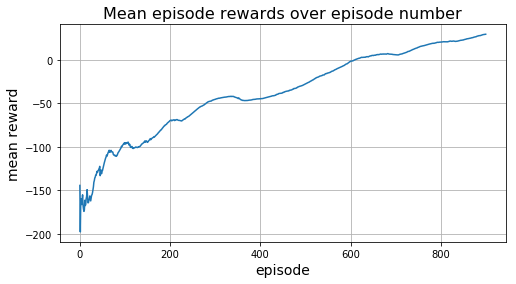

In [7]:
plt.figure(figsize=(8,4))
plt.plot(mean_reward)
plt.xlabel("episode", fontsize=14)
plt.ylabel("mean reward", fontsize = 14)
plt.title("Mean episode rewards over episode number", fontsize = 16)
plt.grid()

### Watch the agent play an episode

This is the fun part!
Now we get to see how good our agent really is by watching it play an episode.

In [ ]:
ep_reward = []
env = gym.make('LunarLander-v2')
env._max_episode_steps = 1000
# env = gym.wrappers.Monitor(env, "recording")
with tf.Session() as sess:
    saver.restore(sess, "models/LunarLander/model.ckpt") # load model
    obs = env.reset() # Reset env and save observation
    t = 0
    while True:
        env.render() # Render game
        # Use our model to create a probability distribution of actions based on observation
        apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,obs_dim[0]))}))
        # Choose an action out of the PDF and take action
        action = np.random.choice(np.arange(num_actions), p = apd)
        obs, reward, done, info = env.step(action)
        ep_reward.append(reward)
        t = t+1
        if done:
            print("Game ended after {} steps".format(t+1))
            print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
            break
env.close()

INFO:tensorflow:Restoring parameters from models/LunarLander/model.ckpt


### Test the trained model performance

In [9]:
num_ep = 10
ep_reward = []
batch_reward = []
env = gym.make('LunarLander-v2')
env._max_episode_steps = 1000
with tf.Session() as sess:
    saver.restore(sess, "models/LunarLander/model.ckpt") # load model
    for ep in range(num_ep):
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,obs_dim[0]))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(num_actions), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward)
            t = t+1
            if done:
                print("-------------------------------------------")
                print("Game ended after {} steps".format(t+1))
                print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
                batch_reward.append(sum(ep_reward))
                ep_reward = []
                break
print("===================================================")
print("Average reward in batch is {:0.2f}".format(np.mean(batch_reward)))

INFO:tensorflow:Restoring parameters from models/LunarLander/model.ckpt
-------------------------------------------
Game ended after 1001 steps
Total reward earned in this episode: 94.57
-------------------------------------------
Game ended after 379 steps
Total reward earned in this episode: 271.22
-------------------------------------------
Game ended after 1001 steps
Total reward earned in this episode: 97.50
-------------------------------------------
Game ended after 1001 steps
Total reward earned in this episode: 87.84
-------------------------------------------
Game ended after 793 steps
Total reward earned in this episode: 183.78
-------------------------------------------
Game ended after 1001 steps
Total reward earned in this episode: 137.63
-------------------------------------------
Game ended after 699 steps
Total reward earned in this episode: 207.01
-------------------------------------------
Game ended after 115 steps
Total reward earned in this episode: 36.72
--------